### Курсовая работа#

### -- Автор: Шенк Евгений Станиславович

Данные для проекта.

Датасет: Обзор статистики самоубийств с 1985 по 2016 г. в разных странах

https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016

### Задачи.

Проверить зависимость количества с.у. от ВВП на душу населения.

Провести анализ по странам, имеются ли значимые различия в статистике стран с одинаковым ВВП в разных возрастных категориях.

Проверить гипотезу что в Российской Федерации количество с.у. в среднем выше, чем в других странах с похожим ВВП или ВВП на душу населения.

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Suicide_Rates_Overview.csv')

In [3]:
#Удаляем параметр 'HDI for year' т.к. там очень много пропусков, а 'country-year' повторяет данные
df = df.drop(columns=['HDI for year', 'country-year'])
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 10 columns):
country               27820 non-null object
year                  27820 non-null int64
sex                   27820 non-null object
age                   27820 non-null object
suicides_no           27820 non-null int64
population            27820 non-null int64
suicides/100k pop     27820 non-null float64
 gdp_for_year ($)     27820 non-null object
gdp_per_capita ($)    27820 non-null int64
generation            27820 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 2.1+ MB


In [5]:
df.describe()

,year,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,126352.000000


### Список стран для которых имеется статистика (например здесь отсутствует Китай)

In [7]:
df.country.unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

### Построим схему корреляций в данном датафрейме.

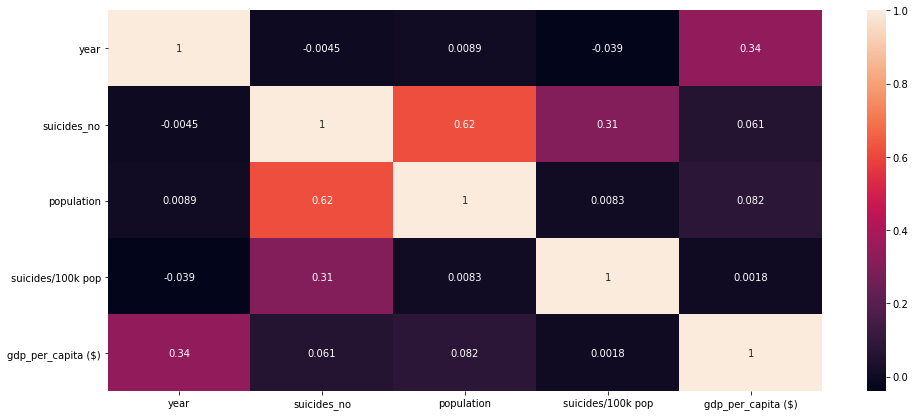

In [8]:
plt.figure(figsize=(16,7))
cor = sns.heatmap(df.corr(), annot = True)

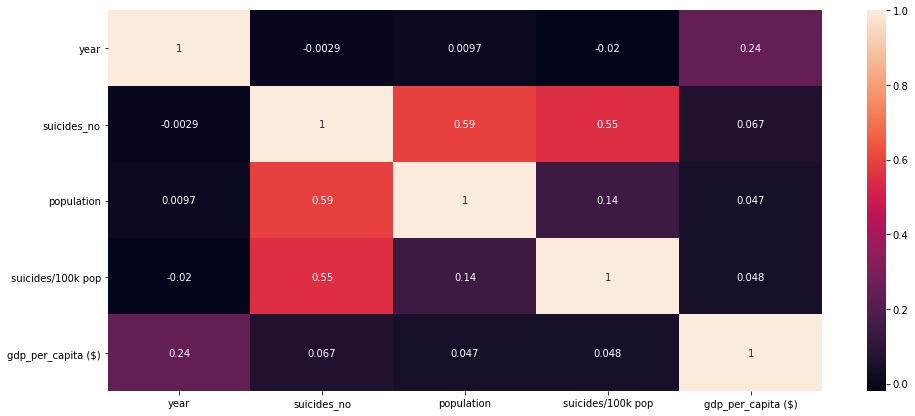

In [9]:
plt.figure(figsize=(16,7))
cor = sns.heatmap(df.corr(method='kendall'), annot = True)

### Каких-то существенный корреляций у параметра 'suicides/100k pop' (кол-во с.у. на 100к населения) и 'gdp_per_capita' (ВВП на душу населения) НЕ наблюдается.

In [10]:
# В данный датафрейм объединим информацию по средним 'suicides/100k pop' и 'gdp_per_capita ($)' 
# в зависимости от страны и по годам
stats_1 = df.groupby(['country', 'year'], as_index=False)[['suicides/100k pop', 'gdp_per_capita ($)']].mean()
stats_1.head()

,country,year,suicides/100k pop,gdp_per_capita ($)
0,Albania,1987,2.654167,796
1,Albania,1988,2.705000,769
2,Albania,1989,2.783333,833
3,Albania,1992,1.500000,251
4,Albania,1993,2.713333,437


### Рассмотрим данные и попробуем построить модель линейной регрессии.

In [11]:
gpd_per_capita = stats_1['gdp_per_capita ($)'].to_numpy()
suicide = stats_1['suicides/100k pop'].to_numpy()

gpd = stats_1['gdp_per_capita ($)'].to_numpy()
ones = np.ones((gpd.shape[0], 1))
gpd = np.hstack((ones, gpd.reshape(len(gpd),1)))

XTX = gpd.T.dot(gpd)
np.linalg.det(XTX)
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(gpd.T).dot(suicide)

In [12]:
# Коэффициент детерминации:
z = b[0] + b[1] * gpd_per_capita
R = 1 - (z - suicide).var() / suicide.var()
R

1.1439947149805008e-05

### Коэффициент детерминации очень мал, следовательно зависимость практически отсутствует.

Text(0, 0.5, 'suicides/100k pop')

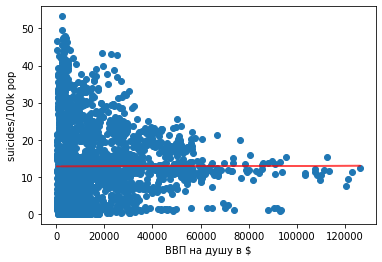

In [13]:
x = gpd
y = b[0] + b[1] * x

plt.scatter(gpd_per_capita, suicide)
plt.plot(x, y, color='red', alpha=0.7)

plt.xlabel('ВВП на душу в $')
plt.ylabel('suicides/100k pop')

### По графику видно, что линейная зависимость отсутствует.

## Далее рассмотрим имеются ли значимые различия в статистике стран с одинаковым ВВП в разных возрастных категориях

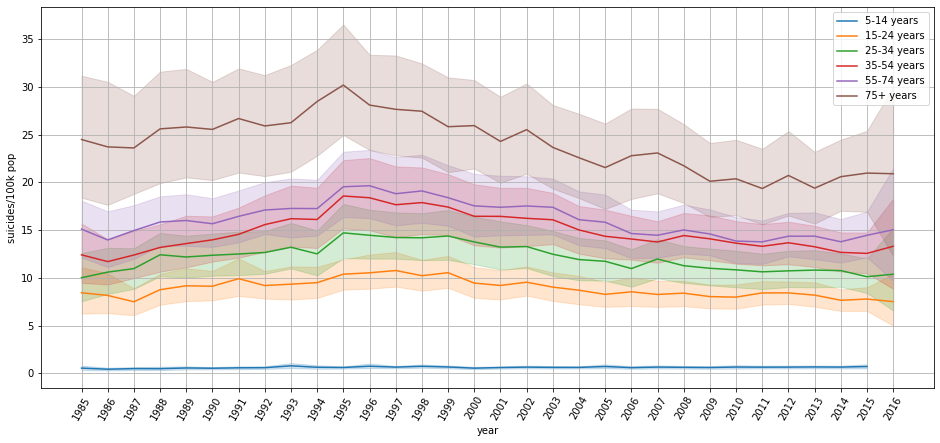

In [14]:
# График зависимости 'suicides/100k pop' от возраста по всем странам
age_05 = df.loc[df.loc[:, 'age']=='5-14 years',:]
age_15 = df.loc[df.loc[:, 'age']=='15-24 years',:]
age_25 = df.loc[df.loc[:, 'age']=='25-34 years',:]
age_35 = df.loc[df.loc[:, 'age']=='35-54 years',:]
age_55 = df.loc[df.loc[:, 'age']=='55-74 years',:]
age_75 = df.loc[df.loc[:, 'age']=='75+ years',:]

plt.figure(figsize=(16,7))

age_05_lp = sns.lineplot(x='year', y='suicides/100k pop', data=age_05)
age_15_lp = sns.lineplot(x='year', y='suicides/100k pop', data=age_15)
age_25_lp = sns.lineplot(x='year', y='suicides/100k pop', data=age_25)
age_35_lp = sns.lineplot(x='year', y='suicides/100k pop', data=age_35)
age_55_lp = sns.lineplot(x='year', y='suicides/100k pop', data=age_55)
age_75_lp = sns.lineplot(x='year', y='suicides/100k pop', data=age_75)

legend = plt.legend(['5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years'])
grid = plt.grid()
xticks = plt.xticks(np.arange(1985, 2017, step=1), rotation=60)

## На данном графике видно, что сильно выбивается группа 5-14 лет, т.к. у этой группы общее количество с.у. очень низкое (показано на графике ниже), а так же группа 75+ лет, что с одной стороны странно, но это возникает из-за сильно меньшего общего количества людей 75+ (через 1 график ниже)

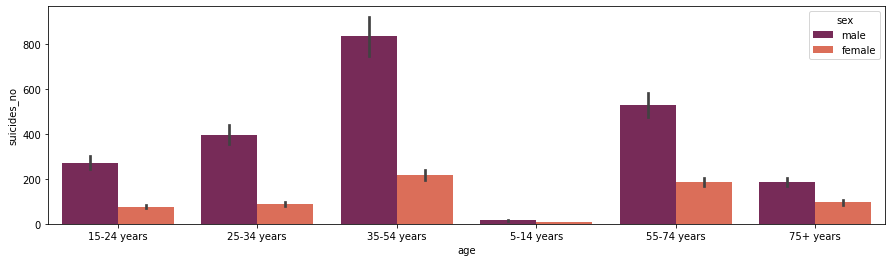

In [15]:
# График абсолютного количества с.у. в зависимости от возраста и пола по всем странам
f,ax = plt.subplots(1,1,figsize=(15,4))
ax = sns.barplot(x = df.age.sort_values(), y = 'suicides_no', hue='sex', data=df, palette='rocket')
plt.show()

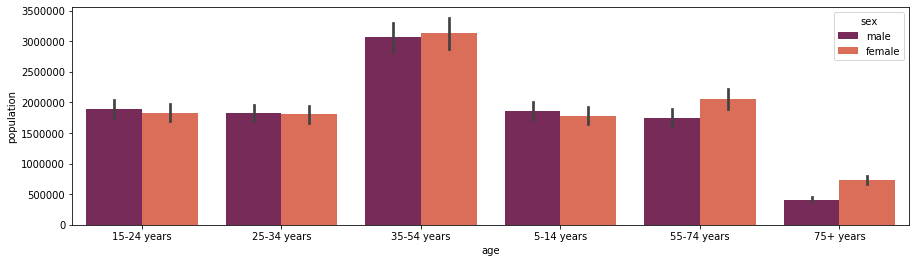

In [16]:
# График абсолютного количества людей в зависимости от возраста и пола по всем странам
f,ax = plt.subplots(1,1,figsize=(15,4))
ax = sns.barplot(x = df.age.sort_values(), y = 'population', hue='sex', data=df, palette='rocket')
plt.show()

## Разделим данные на 4 части по ВВП на душу (0-25, 25-50, 50-75, 75-100 % от максимального ВВП на душу в каждый год)

In [17]:
stats_year = df.groupby(['year'], as_index=False)[['gdp_per_capita ($)']].max().rename(columns={'gdp_per_capita ($)':'gdp_per_capita ($) _max'})
stats_2 = pd.merge(df, stats_year, on='year', how='left')

gdp_25 = stats_2.loc[stats_2['gdp_per_capita ($)']<=stats_2['gdp_per_capita ($) _max']*0.25] 
gdp_50 = stats_2.loc[(stats_2['gdp_per_capita ($)']<=stats_2['gdp_per_capita ($) _max']*0.50) & (stats_2['gdp_per_capita ($)']>stats_2['gdp_per_capita ($) _max']*0.25)]
gdp_75 = stats_2.loc[(stats_2['gdp_per_capita ($)']<=stats_2['gdp_per_capita ($) _max']*0.75) & (stats_2['gdp_per_capita ($)']>stats_2['gdp_per_capita ($) _max']*0.50)]
gdp_100 = stats_2.loc[stats_2['gdp_per_capita ($)']>stats_2['gdp_per_capita ($) _max']*0.75]

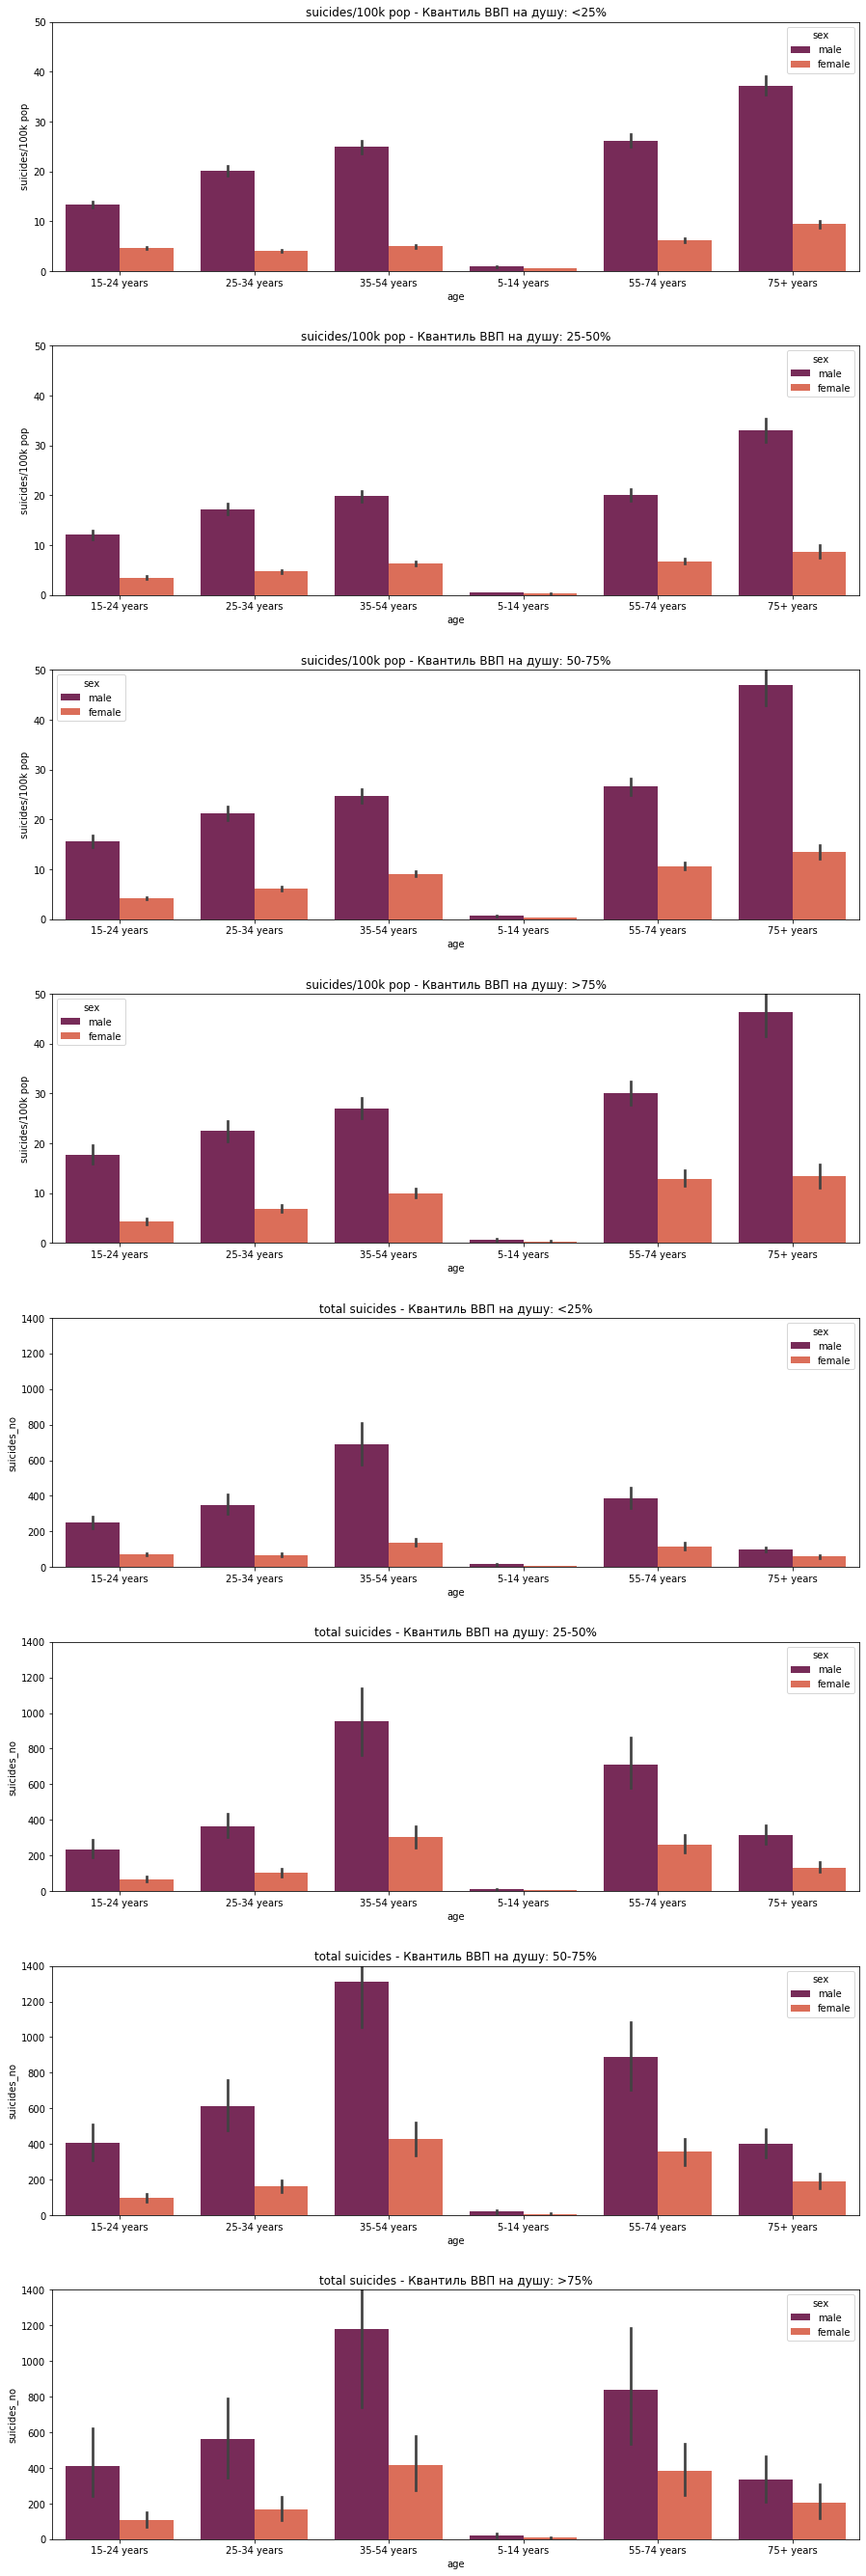

In [18]:
fig, axes = plt.subplots(nrows=8, ncols=1, squeeze=False)
fig.set_size_inches(15, 48)
plt.subplots_adjust(hspace=0.3)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

ax1.set(title='suicides/100k pop - Квантиль ВВП на душу: <25%')
ax1.set_ylim(0, 50)
ax2.set(title='suicides/100k pop - Квантиль ВВП на душу: 25-50%')
ax2.set_ylim(0, 50)
ax3.set(title='suicides/100k pop - Квантиль ВВП на душу: 50-75%')
ax3.set_ylim(0, 50)
ax4.set(title='suicides/100k pop - Квантиль ВВП на душу: >75%')
ax4.set_ylim(0, 50)

ax5.set(title='total suicides - Квантиль ВВП на душу: <25%')
ax5.set_ylim(0, 1400)
ax6.set(title='total suicides - Квантиль ВВП на душу: 25-50%')
ax6.set_ylim(0, 1400)
ax7.set(title='total suicides - Квантиль ВВП на душу: 50-75%')
ax7.set_ylim(0, 1400)
ax8.set(title='total suicides - Квантиль ВВП на душу: >75%')
ax8.set_ylim(0, 1400)

hue_order = ['male','female']
g1 = sns.barplot(x = gdp_25.age.sort_values(), y = 'suicides/100k pop', hue='sex', hue_order=hue_order, data=gdp_25, palette='rocket', ax=axes[0, 0])
g2 = sns.barplot(x = gdp_50.age.sort_values(), y = 'suicides/100k pop', hue='sex', hue_order=hue_order, data=gdp_50, palette='rocket', ax=axes[1, 0])
g3 = sns.barplot(x = gdp_75.age.sort_values(), y = 'suicides/100k pop', hue='sex', hue_order=hue_order, data=gdp_75, palette='rocket', ax=axes[2, 0])
g4 = sns.barplot(x = gdp_100.age.sort_values(), y = 'suicides/100k pop', hue='sex', hue_order=hue_order, data=gdp_100, palette='rocket', ax=axes[3, 0])

g5 = sns.barplot(x = gdp_25.age.sort_values(), y = 'suicides_no', hue='sex', hue_order=hue_order, data=gdp_25, palette='rocket', ax=axes[4, 0])
g6 = sns.barplot(x = gdp_50.age.sort_values(), y = 'suicides_no', hue='sex', hue_order=hue_order, data=gdp_50, palette='rocket', ax=axes[5, 0])
g7 = sns.barplot(x = gdp_75.age.sort_values(), y = 'suicides_no', hue='sex', hue_order=hue_order, data=gdp_75, palette='rocket', ax=axes[6, 0])
g8 = sns.barplot(x = gdp_100.age.sort_values(), y = 'suicides_no', hue='sex', hue_order=hue_order, data=gdp_100, palette='rocket', ax=axes[7, 0])

plt.show()

## Выводы:
### Получаем что количество с.у. у мужчин больше чем у женщин, 
### Количество с.у. на 100 тысяч человек из той же группы растет вместе с увеличением возраста,  
### Количество с.у. НЕ зависит от ВВП на душу населения, а в абсолютных значениях чуть ниже в бедных странах

## Далее. Проверим гипотезу что в Российской Федерации количество с.у. в среднем выше, чем в других странах с похожим ВВП или ВВП на душу населения.

Создаем датафреймы со странами у которых средний ВВП на душу начиная с 2012 года чуть больше чем в России и у которых чуть меньше, а далее находим среднее значение 'suicides/100k pop' по годам для датафреймов. У нас получатся:

russia - статистика по России

counties_more - набор стран у которых ВВП больше (100-150% от Российского)

counties_less - набор стран у которых ВВП меньше (100-150% от Российского)

not_russia_more - 'suicides/100k pop' по годам для тех у кого ВВП больше (100-150% от Российского)

not_russia_less - 'suicides/100k pop' по годам для тех у кого ВВП меньше (75-100% от Российского)

In [19]:
russia = stats_1.loc[stats_1['country']=='Russian Federation']

counties = stats_1.loc[stats_1['year']>=2012].groupby(['country'], as_index=False)[['gdp_per_capita ($)']].mean()

russia_gpd_mean = counties.loc[counties['country']=='Russian Federation', 'gdp_per_capita ($)'].mean()

counties_more = counties.loc[(counties['country']!='Russian Federation') & (counties['gdp_per_capita ($)']>russia_gpd_mean) & (counties['gdp_per_capita ($)']<russia_gpd_mean*1.5)]
counties_less = counties.loc[(counties['country']!='Russian Federation') & (counties['gdp_per_capita ($)']>russia_gpd_mean*0.75) & (counties['gdp_per_capita ($)']<russia_gpd_mean)]

In [20]:
c_more = pd.merge(counties_more['country'], stats_1, on='country', how='left')
c_less = pd.merge(counties_less['country'], stats_1, on='country', how='left')
not_russia_more = c_more.groupby(['year'], as_index=False)[['suicides/100k pop']].mean()
not_russia_less = c_less.groupby(['year'], as_index=False)[['suicides/100k pop']].mean()

In [21]:
not_russia_less.head()

,year,suicides/100k pop
0,1985,4.893611
1,1986,5.646528
2,1987,5.682639
3,1988,5.597083
4,1989,5.434306


### Проверить гипотезу у равенстве средних 'suicides/100k pop' по каждой группе. Для проверки этой гипотезы воспользуемся однофакторным дисперсионным анализом.

In [22]:
y1 = russia['suicides/100k pop'].to_numpy()
y2 = not_russia_more['suicides/100k pop'].to_numpy()
y3 = not_russia_less['suicides/100k pop'].to_numpy()

n1 = y1.shape[0]
n2 = y2.shape[0]
n3 = y3.shape[0]

y1_mean = y1.mean()
y2_mean = y2.mean()
y3_mean = y3.mean()

y = np.concatenate([y1, y2, y3])
y_mean = y.mean()

S2_b = n1 * (y1_mean - y_mean) ** 2 + n2 * (y2_mean - y_mean) ** 2 + n3 * (y3_mean - y_mean) ** 2
S2_w = ((y1 - y1_mean) ** 2).sum() + ((y2 - y2_mean) ** 2).sum() + ((y3 - y3_mean) ** 2).sum()

k = 3
n = n1 + n2

k1 = k - 1
k2 = n - k

sigma2_b = S2_b / k1
sigma2_w = S2_w / k2

F = sigma2_b / sigma2_w
F

75.94926635625947

In [23]:
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

3.161861164913022

In [24]:
y1_mean, y2_mean, y3_mean

(34.89237654320988, 15.89592505787037, 12.60854090195106)

### $F > F_{crit}$, следовательно отличие усредненных 'suicides/100k pop' в России и в странах с 'ВВП на душу' чуть больше и чуть меньше чем в России является статистически значимым.

### Для наглядности построим графики с усредненными значениями за все время

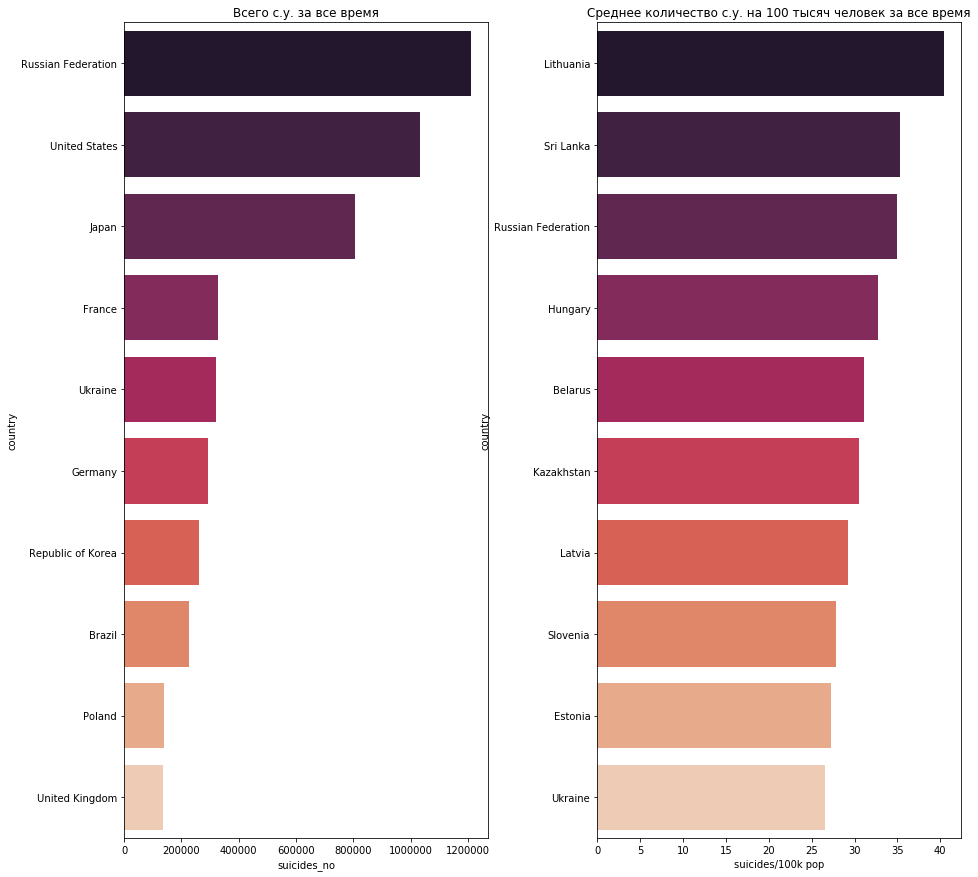

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15), squeeze=False)
plt.subplots_adjust(wspace=0.3)

ax1, ax2 = axes.flatten()

data_suicide_total = df['suicides_no'].groupby(df.country).sum().sort_values(ascending=False)
data_suicide_per100 = df['suicides/100k pop'].groupby(df.country).mean().sort_values(ascending=False)

ax1.set(title='Всего с.у. за все время')
ax2.set(title='Среднее количество с.у. на 100 тысяч человек за все время')

g1 = sns.barplot(data_suicide_total.head(10),data_suicide_total.head(10).index, palette='rocket', ax=axes[0, 0])
g2 = sns.barplot(data_suicide_per100.head(10),data_suicide_per100.head(10).index, palette='rocket', ax=axes[0, 1])

## Выводы:
### Получаем что в России количество с.у. больше не только в группе стран с похожим ВВП, но и в целом имеет самое большое количество с.у. за все время из всех представленых стран.